In [0]:

# define widgets - NEED TO DEFINE IT ONCE
# dynamic variables (pass it from ADF)
# first time runtime parameter
# dbutils.widgets.dropdown("environment", "dev", ["dev","uat","prod"])
# dbutils.widgets.dropdown("new_training", "False", ["True","False"])
# dbutils.widgets.dropdown("system_name", "bimodelapi", ["bimodelapi"])
# dbutils.widgets.text("system_name", "","")
# dbutils.widgets.remove("pbiapi")
environment = dbutils.widgets.get("environment")
new_training = dbutils.widgets.get("new_training")
system_name = dbutils.widgets.get("system_name")
if environment in {"prod"}:
    aml_compute_cluster_name = "cc-bi-ml-prod01"
else:
    aml_compute_cluster_name = "cc-bi-ml-devqa01"

print(environment, system_name, new_training, aml_compute_cluster_name)



dev bimodelapi False cc-bi-ml-devqa01

In [0]:
%run /bi_config/lib_helper

In [0]:
%run /bi_config/lib_sentry

In [0]:
%run ./helper

In [0]:

# ============================= pyspark libraries import ===================================#
from pyspark.sql.functions import (
    col,
    concat,
    lit,
    current_date,
    lag,
    lead,
    first,
    last,
    desc,
    hash,
    row_number,
)
from datetime import date, timedelta, datetime
from pyspark.sql import functions as F
from pyspark.sql import *
from delta.tables import *
from pyspark.sql.types import TimestampType, LongType, StringType

# from ibi_packages import functions as fn
import os
import stringcase
from pyspark.sql import SQLContext
from pyspark.sql.window import Window



In [0]:

# ================= Load BI config parameters data (overwrite) =================#W
# static variables
environment_name = environment
filename = "automlrevfoecastconfig.json"

today = pd.to_datetime("today").normalize()
current_eom = today + pd.offsets.MonthEnd(0)
start_date = "2017-01-01"
end_date = current_eom + pd.offsets.MonthEnd(11)

notebook = os.path.basename(getNotebookPath())

input_data_path = "/dbfs/mnt/" + environment + "/automl_rev_region_forecast/inputs/"
output_data_path = "/dbfs/mnt/" + environment + "/automl_rev_region_forecast/outputs/"
blobstore_datadir = "revregionforecast_data/"

bi_config_parameter_filepath = "/mnt/{}/automl_rev_region_forecast/config/{}".format(
    environment_name, filename
)

try:
    # read JSON file
    df_bi_config_parameters = (
        spark.read.format("json")
        .option("multiline", "true")
        .load(bi_config_parameter_filepath)
    )
    df_bi_config_parameters = df_bi_config_parameters.filter(
        df_bi_config_parameters.SystemName == lit(system_name)
    )
    display(df_bi_config_parameters)

    # adding audit fields
    # df_bi_config_parameters = df_bi_config_parameters.withColumn("IBICreatedBy",lit(ibi_created_by))
    # df_bi_config_parameters = df_bi_config_parameters.withColumn("IBIUpdatedBy",lit(ibi_updated_by))
    # df_bi_config_parameters = df_bi_config_parameters.withColumn("IBICreatedDate",lit(ibi_created_date).cast(TimestampType()))
    # df_bi_config_parameters = df_bi_config_parameters.withColumn("IBIUpdatedDate",lit(ibi_updated_date).cast(TimestampType()))
    # df_bi_config_parameters = df_bi_config_parameters.withColumn('ID', row_number().over(Window.orderBy('EnvironmentName','SystemName')))

    # initializing config parameter values

    # subscription_id = "db61fd47-db56-45e3-844f-1b1f5c47990a" #you should be owner or contributor
    subscription_id = dbutils.secrets.get(
        scope="kv-bi-devqa-01-secrets", key="subscription-id"
    )

    resource_group = (
        df_bi_config_parameters.filter(
            df_bi_config_parameters.ParameterName == "ws_resource_group"
        )
        .select("ParameterValue")
        .collect()[0][0]
    )
    workspace_name = (
        df_bi_config_parameters.filter(
            df_bi_config_parameters.ParameterName == "workspace_name"
        )
        .select("ParameterValue")
        .collect()[0][0]
    )
    workspace_region = (
        df_bi_config_parameters.filter(
            df_bi_config_parameters.ParameterName == "workspace_region"
        )
        .select("ParameterValue")
        .collect()[0][0]
    )


except Exception as error:
    log_error("{} {}".format(notebook, error))



EnvironmentName,ParameterName,ParameterValue,SystemName
dev,ws_resource_group,rg-bi-automl-devqa01,bimodelapi
dev,workspace_name,mlw-bi-automl-devqa01,bimodelapi
dev,workspace_region,westus,bimodelapi


0 : ^GSPC,1 : ^FTSE,2 : ^N100,3 : ^N225,4 : 000001.SS,

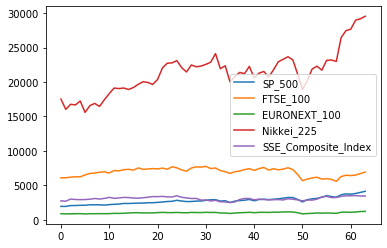

In [0]:

# download adjusted closing prices from Yahoo finance
#!pip install pandas_datareader
#!pip install yfinance
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io

pd.set_option("display.float_format", lambda x: "%.2f" % x)

start = datetime.datetime(2016, 1, 1)
end = today

# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
symbols = [
    "^GSPC",
    "^FTSE",
    "^N100",
    "^N225",
    "000001.SS",
]
symbols_name = [
    "SP_500",
    "FTSE_100",
    "EURONEXT_100",
    "Nikkei_225",
    "SSE_Composite_Index",
]


# create empty dataframe
stock_final = pd.DataFrame()
# iterate over each symbol
for i in symbols:

    # print the symbol which is being downloaded
    print(str(symbols.index(i)) + str(" : ") + i, sep=",", end=",", flush=True)

    try:
        # download the stock price
        stock = []
        stock = yf.download(i, start=start, end=end, progress=False)

        # append the individual stock prices
        if len(stock) == 0:
            None
        else:
            stock["Name"] = i
            stock_final = stock_final.append(stock, sort=False)
    except Exception as error:
        print(error)
        log_error("{} {}".format(notebook, error)) #log error in sentry
        raise dbutils.notebook.exit(error) #raise the exception

# display(stock_final.tail())

stock_final1 = stock_final.copy()
stock_final1 = stock_final1.reset_index(level=stock_final1.index.names)

stock_final1["Name"].where(stock_final1["Name"] != "^N225", "Nikkei_225", inplace=True)
stock_final1["Name"].where(
    stock_final1["Name"] != "000001.SS", "SSE_Composite_Index", inplace=True
)
stock_final1["Name"].where(stock_final1["Name"] != "^GSPC", "SP_500", inplace=True)
stock_final1["Name"].where(stock_final1["Name"] != "^FTSE", "FTSE_100", inplace=True)
stock_final1["Name"].where(
    stock_final1["Name"] != "^N100", "EURONEXT_100", inplace=True
)

stock_final1["End_of_Month"] = stock_final1["Date"] + pd.offsets.MonthEnd(0)


# display(stock_final1.tail())
stock_final1 = stock_final1.sort_values("Date").groupby(["End_of_Month", "Name"]).last()
stock_final1 = stock_final1.drop(
    ["Date", "Open", "High", "Low", "Close", "Volume"], axis=1
)
stock_final1 = stock_final1.reset_index(level=stock_final1.index.names)

# Drop all Not a number values using drop method.
stock_final1.dropna(inplace=True)
stock_final_pivot = stock_final1.pivot_table(
    index="End_of_Month", values="Adj Close", margins=False, columns=["Name"]
)
# aggfunc=['sum','count'],

# revhist_pivot = revhist_pivot.rename(columns={'sum':'Revenue'})

stock_final_pivot = stock_final_pivot.reset_index(
    level=stock_final_pivot.index.names
).reset_index(drop=True)

# revhist_pivot['End_of_Month'] = pd.to_datetime(revhist_pivot['End_of_Month'])#.dt.date
# revhist_pivot.index.name = 'Date'

stock_final_pivot.fillna(0, inplace=True)
# stock_final1.query('Name=="Nikkei 225"').plot(title=str(i))
#display(stock_final_pivot.info())
#display(stock_final_pivot.tail())
for i in symbols_name:
    stock_final_pivot[i].plot(legend=True)



In [0]:

# Load Power BI Data into pandas Dataframe
# https://stbidatadevqa01.dfs.core.windows.net/dev/automl_rev_region_forecast

# Ingest power bi data

import glob

init_time_column_name = "End of Month"
init_time_column_name1 = "Snapshot Date Short"
init_time_column_name2 = "Snapshot End of Month"
try:
    talenthist = pd.read_csv(
        input_data_path + "TalentHistory.csv", parse_dates=[init_time_column_name]
    )
    revhist = pd.read_csv(
        input_data_path + "RevenueHistory.csv", parse_dates=[init_time_column_name]
    )
    opphist = pd.read_csv(
        input_data_path + "OppHistory.csv", parse_dates=[init_time_column_name]
    )
    projhist = pd.read_csv(
        input_data_path + "ProjectHistory.csv", parse_dates=[init_time_column_name]
    )
    pipetrend = pd.read_csv(
        input_data_path + "PipelineTrend.csv",
        parse_dates=[init_time_column_name1, init_time_column_name2],
    )
    projectactualshist = pd.read_csv(
        input_data_path + "ProjectActualsHistory.csv",
        parse_dates=[init_time_column_name],
    )

    # pipehist = pd.read_csv(input_data_path + 'PipelineHistory*.csv',
    #                       parse_dates=[init_time_column_name,
    #                       init_time_column_name1])

    pipehist = pd.concat(
        [
            pd.read_csv(f, parse_dates=[init_time_column_name, init_time_column_name1])
            for f in glob.glob(input_data_path + "PipelineHistory*.csv")
        ],
        ignore_index=True,
    )

    # Remove Percentage from numbers if existinput_data_path + 'PipelineHistory*.csv'

    # opphist1.filter(like="Win_Rate", axis=1).columns

    cols_float1 = ["Win Rate"]
    remove_percetage(opphist, cols_float1)
    cols_float2 = ["Yield"]
    remove_percetage(pipehist, cols_float2)
    cols_float3 = ["Utilization Billable"]
    remove_percetage(projectactualshist, cols_float3)
    
    file_list = [
        pipehist,
        talenthist,
        revhist,
        opphist,
        projhist,
        pipetrend,
        projectactualshist
    ]

    for x in file_list:

        # replace blank with underscore

        x.columns = x.columns.astype(str).str.replace(" ", "_")

        # remove contrib or managing

        x.columns = x.columns.astype(str).str.replace("Contrib_", "")
        x.columns = x.columns.astype(str).str.replace("Managing_", "")
        '''
        display(x.info())
        display(x.tail())
        '''
        print(get_df_name(x), ":", x.shape)
except Exception as error:
    print(error)
    log_error("{} {}".format(notebook, error)) #log error in sentry
    raise dbutils.notebook.exit(error) #raise the exception



pipehist : (82410, 9)
talenthist : (4591, 6)
revhist : (430, 3)
opphist : (593, 7)
projhist : (701, 7)
pipetrend : (1245, 4)
projectactualshist : (1697, 4)

In [0]:
pipehist["Snapshot_Date_Short"].unique()

Out[10]: array(['2020-02-16T00:00:00.000000000', '2020-02-23T00:00:00.000000000',
 '2020-02-29T00:00:00.000000000', '2020-03-01T00:00:00.000000000',
 '2020-03-08T00:00:00.000000000', '2020-03-15T00:00:00.000000000',
 '2020-03-22T00:00:00.000000000', '2020-06-07T00:00:00.000000000',
 '2020-06-14T00:00:00.000000000', '2020-06-21T00:00:00.000000000',
 '2020-06-28T00:00:00.000000000', '2020-06-30T00:00:00.000000000',
 '2020-07-05T00:00:00.000000000', '2020-07-12T00:00:00.000000000',
 '2020-07-19T00:00:00.000000000', '2020-07-26T00:00:00.000000000',
 '2020-07-31T00:00:00.000000000', '2020-08-02T00:00:00.000000000',
 '2020-08-09T00:00:00.000000000', '2020-08-16T00:00:00.000000000',
 '2020-08-23T00:00:00.000000000', '2020-08-30T00:00:00.000000000',
 '2020-08-31T00:00:00.000000000', '2020-09-06T00:00:00.000000000',
 '2020-09-13T00:00:00.000000000', '2020-09-20T00:00:00.000000000',
 '2020-09-27T00:00:00.000000000', '2020-09-30T00:00:00.000000000',
 '2020-10-04T00:00:00.000000000', '2020-10-11T00:00:00.000000000',
 '2020-10-18T00:00:00.000000000', '2020-10-25T00:00:00.000000000',
 '2020-10-31T00:00:00.000000000', '2020-11-01T00:00:00.000000000',
 '2020-11-08T00:00:00.000000000', '2020-11-15T00:00:00.000000000',
 '2020-11-22T00:00:00.000000000', '2020-11-29T00:00:00.000000000',
 '2020-11-30T00:00:00.000000000', '2020-12-06T00:00:00.000000000',
 '2020-12-13T00:00:00.000000000', '2020-12-20T00:00:00.000000000',
 '2020-12-27T00:00:00.000000000', '2020-12-31T00:00:00.000000000',
 '2021-01-03T00:00:00.000000000', '2021-01-10T00:00:00.000000000',
 '2021-01-17T00:00:00.000000000', '2021-01-24T00:00:00.000000000',
 '2021-01-31T00:00:00.000000000', '2021-02-07T00:00:00.000000000',
 '2021-02-14T00:00:00.000000000', '2021-02-21T00:00:00.000000000',
 '2021-02-28T00:00:00.000000000', '2021-03-07T00:00:00.000000000',
 '2021-03-14T00:00:00.000000000', '2021-03-21T00:00:00.000000000',
 '2021-03-28T00:00:00.000000000', '2021-03-31T00:00:00.000000000',
 '2021-04-04T00:00:00.000000000', '2021-04-05T00:00:00.000000000',
 '2021-04-06T00:00:00.000000000', '2021-04-07T00:00:00.000000000',
 '2021-04-08T00:00:00.000000000', '2021-04-09T00:00:00.000000000',
 '2021-04-10T00:00:00.000000000', '2021-04-11T00:00:00.000000000',
 '2019-11-24T00:00:00.000000000', '2019-11-30T00:00:00.000000000',
 '2019-12-01T00:00:00.000000000', '2019-12-08T00:00:00.000000000',
 '2019-12-15T00:00:00.000000000', '2019-12-22T00:00:00.000000000',
 '2019-12-29T00:00:00.000000000', '2019-12-31T00:00:00.000000000',
 '2020-01-05T00:00:00.000000000', '2020-01-12T00:00:00.000000000',
 '2020-01-19T00:00:00.000000000', '2020-01-26T00:00:00.000000000',
 '2020-01-31T00:00:00.000000000', '2020-02-02T00:00:00.000000000',
 '2020-02-09T00:00:00.000000000', '2020-03-29T00:00:00.000000000',
 '2020-03-31T00:00:00.000000000', '2020-04-05T00:00:00.000000000',
 '2020-04-12T00:00:00.000000000', '2020-04-19T00:00:00.000000000',
 '2020-04-26T00:00:00.000000000', '2020-04-30T00:00:00.000000000',
 '2020-05-03T00:00:00.000000000', '2020-05-10T00:00:00.000000000',
 '2020-05-17T00:00:00.000000000', '2020-05-24T00:00:00.000000000',
 '2020-05-31T00:00:00.000000000', '2019-07-28T00:00:00.000000000',
 '2019-07-31T00:00:00.000000000', '2019-08-04T00:00:00.000000000',
 '2019-08-11T00:00:00.000000000', '2019-08-18T00:00:00.000000000',
 '2019-08-25T00:00:00.000000000', '2019-08-31T00:00:00.000000000',
 '2019-09-01T00:00:00.000000000', '2019-09-08T00:00:00.000000000',
 '2019-09-15T00:00:00.000000000', '2019-09-22T00:00:00.000000000',
 '2019-09-29T00:00:00.000000000', '2019-09-30T00:00:00.000000000',
 '2019-10-06T00:00:00.000000000', '2019-10-13T00:00:00.000000000',
 '2019-10-20T00:00:00.000000000', '2019-10-27T00:00:00.000000000',
 '2019-10-31T00:00:00.000000000', '2019-11-03T00:00:00.000000000',
 '2019-11-10T00:00:00.000000000', '2019-11-17T00:00:00.000000000',
 '2018-07-20T00:00:00.000000000', '2018-07-22T00:00:00.000000000',
 '2018-07-29T00:00:00.000000000', '2018-07-31T00:00:00.000000000',
 '2018-08-05T00:00:00.000000000'

In [0]:
pipehist["End_of_Month"].unique()

Out[11]: array(['2021-01-31T00:00:00.000000000', '2021-02-28T00:00:00.000000000',
 '2021-03-31T00:00:00.000000000', '2021-04-30T00:00:00.000000000',
 '2021-05-31T00:00:00.000000000', '2021-06-30T00:00:00.000000000',
 '2021-07-31T00:00:00.000000000', '2021-10-31T00:00:00.000000000',
 '2021-11-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000',
 '2022-01-31T00:00:00.000000000', '2021-08-31T00:00:00.000000000',
 '2021-09-30T00:00:00.000000000', '2022-02-28T00:00:00.000000000',
 '2022-03-31T00:00:00.000000000', '2017-01-31T00:00:00.000000000',
 '2017-02-28T00:00:00.000000000', '2017-03-31T00:00:00.000000000',
 '2017-04-30T00:00:00.000000000', '2017-05-31T00:00:00.000000000',
 '2017-06-30T00:00:00.000000000', '2017-07-31T00:00:00.000000000',
 '2017-08-31T00:00:00.000000000', '2017-09-30T00:00:00.000000000',
 '2017-10-31T00:00:00.000000000', '2017-11-30T00:00:00.000000000',
 '2017-12-31T00:00:00.000000000', '2018-01-31T00:00:00.000000000',
 '2018-02-28T00:00:00.000000000', '2018-03-31T00:00:00.000000000',
 '2018-04-30T00:00:00.000000000', '2018-05-31T00:00:00.000000000',
 '2018-06-30T00:00:00.000000000', '2018-07-31T00:00:00.000000000',
 '2018-08-31T00:00:00.000000000', '2018-09-30T00:00:00.000000000',
 '2018-10-31T00:00:00.000000000', '2018-11-30T00:00:00.000000000',
 '2018-12-31T00:00:00.000000000', '2019-01-31T00:00:00.000000000',
 '2019-02-28T00:00:00.000000000', '2019-03-31T00:00:00.000000000',
 '2019-04-30T00:00:00.000000000', '2019-05-31T00:00:00.000000000',
 '2019-06-30T00:00:00.000000000', '2019-07-31T00:00:00.000000000',
 '2019-08-31T00:00:00.000000000', '2019-09-30T00:00:00.000000000',
 '2019-10-31T00:00:00.000000000', '2019-11-30T00:00:00.000000000',
 '2019-12-31T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
 '2020-02-29T00:00:00.000000000', '2020-03-31T00:00:00.000000000',
 '2020-04-30T00:00:00.000000000', '2020-05-31T00:00:00.000000000',
 '2020-06-30T00:00:00.000000000', '2020-07-31T00:00:00.000000000',
 '2020-08-31T00:00:00.000000000', '2020-09-30T00:00:00.000000000',
 '2020-10-31T00:00:00.000000000', '2020-11-30T00:00:00.000000000',
 '2020-12-31T00:00:00.000000000'], dtype='datetime64[ns]')